### Time to get your hands dirty! Can a computer learn if we're going to detect gravitational waves?

This episode of "time to get your hands dirty" is about something I studied carefully in the past: gravitational-wave selection effects. 

All experiments have selection effects. Some sources are easier to detect than others which distorts the population of sources we observe (this crucial in astronomy! Surveys are typically flux limited). 
In order to decided if a feature in the observed population of objects is telling us something new about reality, we need to understand and model our selection effects (for instance: it would be wrong to say that all stars are close by just because we can't observe those that are very far!). In observational astronomy, this is known as [Malmquist bias](https://en.wikipedia.org/wiki/Malmquist_bias) and was first formulated in 1922.
 
**The goal here is to machine-learn the LIGO detectability: can we *predict* if a gravitational-wave source will be detected?**  

[This dataset](https://github.com/dgerosa/pdetclassifier/releases/download/v0.2/sample_2e7_design_precessing_higherordermodes_3detectors.h5) contains simulated gravitational-wave signals from merging black holes (careful the file size is >1 GB). If you've never seen them, the [.h5 format](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) is a highly optimized storage strategy for large datasets. It's amazing. In python, you can read it with `h5py`.

In particular, each source has the following features:
- `mtot`: the total mass of the binary
- `q`: the mass ratio
- `chi1x`, `chi1y`, `chi1z`, `chi2x`, `chi2y`, `chi2z`: the components of the black-hole spins in a suitable reference frame.
- `ra`, `dec`: the location of the source in the sky
- `iota`: the inclination of the orbital plane'
- `psi`: the polarization angle (gravitational waves have two polarization states much like light)
- `z`: the redshift

The detectability is defined using the `snr` (signal-to-noise ratio) computed with a state-of-the-art model of the LIGO/Virgo detector network. Some (many?) of you will have studied this in Sesana's gravitational-wave course; [see here](https://arxiv.org/abs/1908.11170) for a nice write-up. All you need to know now is that we threshold the `snr` values and assume that LIGO will (not) see a source if `snr`>12 (`snr`<12). The resulting 0-1 labels are reported in the `det` attribute in the dataset.

Today's task is to train a classifier (you decide which one!) and separate sources that are detectables from those that aren't. 

Be creative! This is a challenge! Let's see who gets the  higher completeness and/or the smaller contamination (on a validation set, of course! Careful with overfitting here!).

*Tips*:
- You can downsample the data for debugging purposes
- You can also use only some of the features.

### Another idea

Here are other ideas that I haven't explored in a paper (yet?). 

- Using the same data, we could run a regressor on `snr` instead of a classifier on `det`. We can then threshold the predictions (instead of tresholding the data like we're doing now). Would this give a better performance?

- How about trying to reduce the dimensionality of the dataset with a PCA-type algorithm to ease the classification problem?

Please let me know if you give it a try and what you find! 



### Notes
- Choose regression method through ROC curve?
- Change fit_transform into transform
- Compute logistic regression also on not PCA-Isomap data

In [143]:
import numpy as np
import h5py
from sklearn.manifold import Isomap
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

In [144]:
f = h5py.File('copia di sicurezza.h5','r')
dset = []

for idx, name in enumerate(list(f.keys())):
    dset.append(f[name][0:1000])

dset = pd.DataFrame(np.transpose(dset))
dset.columns = list(f.keys())
dset

,chi1x,chi1y,chi1z,chi2x,chi2y,chi2z,dec,det,iota,mtot,psi,q,ra,snr,z
0,-0.307201,0.276165,-0.430760,-0.161114,-0.092334,-0.414647,-0.329671,0.0,1.809310,906.803562,1.286031,0.624780,-3.116784,0.822509,2.139659
1,-0.734712,-0.498493,-0.298162,0.057532,-0.844992,0.014708,0.526740,0.0,0.820820,59.102112,0.934308,0.986650,1.360291,1.093237,2.438707
2,-0.057831,-0.703796,-0.354512,-0.215538,0.016323,0.130543,0.315799,0.0,2.008206,44.602750,1.535520,0.286199,0.079973,1.305398,1.869461
3,0.015260,-0.202467,-0.492768,-0.237033,-0.365363,-0.876192,0.432105,0.0,2.018398,534.378032,3.064086,0.538882,-1.780558,9.112974,0.428061
4,-0.016731,0.007848,0.005007,0.147519,0.231879,0.086716,-0.458711,1.0,2.037363,573.821705,0.752211,0.846310,2.789289,17.525534,0.772609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.576429,-0.645197,0.106358,0.779329,0.480224,0.302788,-0.164741,0.0,1.784171,905.125763,2.367827,0.466528,-0.034750,0.993533,3.260640
996,-0.134131,0.205700,-0.107687,-0.046215,0.361217,-0.813627,-1.245679,0.0,2.560637,264.862843,1.422802,0.642199,2.816555,3.599715,3.244858
997,0.216536,-0.100850,0.299994,0.088451,0.136617,-0.121935,1.036102,1.0,0.415292,408.083801,3.102616,0.756706,-1.027694,20.986058,1.004410
998,0.274411,-0.156249,-0.064642,0.302982,0.366175,0.325817,0.919502,0.0,2.010860,588.336562,3.114282,0.692634,-2.490513,2.113289,2.580256


In [198]:
columns = ['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec','iota', 'mtot', 'psi', 'q', 'ra', 'z']
#columns = ['mtot', 'psi', 'q', 'ra', 'z']

In [199]:
scaler = StandardScaler().set_output(transform="pandas")
X_train, X_test, y_train, y_test = train_test_split(dset[columns], dset['det'], test_size=0.3, random_state=42)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [200]:
Cs = np.logspace(-5, 5, 20)
unscaled_clf = LogisticRegressionCV(Cs=Cs, solver = 'sag',max_iter=5000)
unscaled_clf.fit(X_train, y_train)
scaled_clf = LogisticRegressionCV(Cs=Cs, solver = 'sag',max_iter=5000)
scaled_clf.fit(X_train_scaled, y_train)

print(f"Optimal C for the unscaled dataset: {unscaled_clf.C_[0]:.4f}\n")
print(f"Optimal C for the standardized dataset: {scaled_clf.C_[0]:.2f}")

y_pred = unscaled_clf.predict(X_test)
y_pred_scaled = scaled_clf.predict(X_test_scaled)
y_proba = unscaled_clf.predict_proba(X_test)
y_proba_scaled = scaled_clf.predict_proba(X_test_scaled)

condition = (y_pred == y_test)
print(X_test.shape, X_test[condition].shape)

condition = (y_pred_scaled == y_test)
print(X_test_scaled.shape, X_test_scaled[condition].shape)

Optimal C for the unscaled dataset: 0.5456

Optimal C for the standardized dataset: 6.16
(300, 13) (267, 13)
(300, 13) (286, 13)


In [201]:
accuracy_unscaled = accuracy_score(y_test, y_pred)
accuracy_scaled = accuracy_score(y_test, y_pred_scaled)

Conf_matrix = confusion_matrix(y_test, y_pred_scaled)
tn, fp, fn, tp = Conf_matrix.ravel()
completeness_test_dataset= tp/(tp+fn)
contamination_test_dataset = fp/(tp+fp)

In [309]:
pca = PCA(n_components=7)

(700, 7)


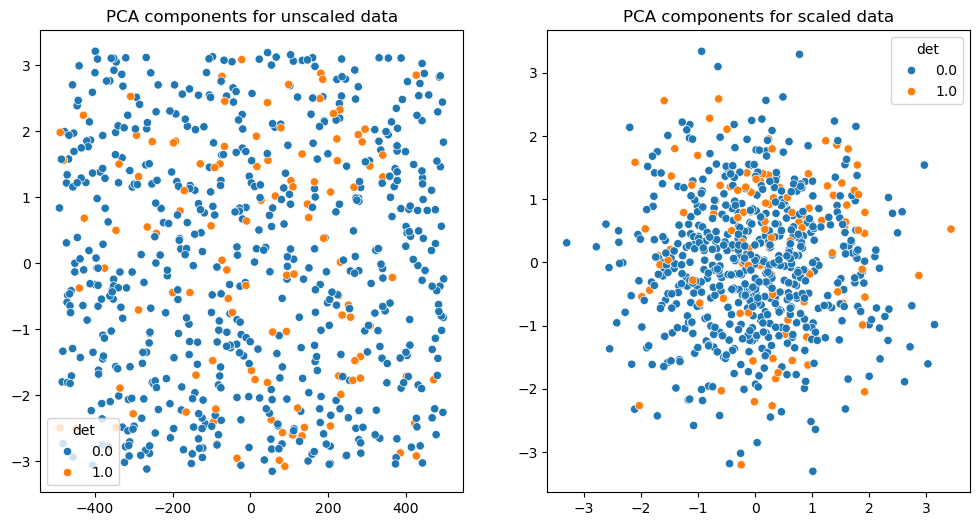

In [310]:
X_train_transformed = pca.fit_transform(X_train)
print(X_train_transformed.shape)
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,2,1)
sns.scatterplot(x = X_train_transformed[:, 0], y = X_train_transformed[:,1], hue = y_train)
plt.title('PCA components for unscaled data')

X_train_transformed_scaled = pca.fit_transform(X_train_scaled)
ax2 = fig.add_subplot(1,2,2)
sns.scatterplot(x = X_train_transformed_scaled[:, 0], y = X_train_transformed_scaled[:,1], hue = y_train)
plt.title('PCA components for scaled data');

In [311]:
embedding = Isomap(n_components=7)
X_train_scaled_isomap = embedding.fit_transform(X_train_scaled)
print(X_train_scaled_isomap.shape)

(700, 7)


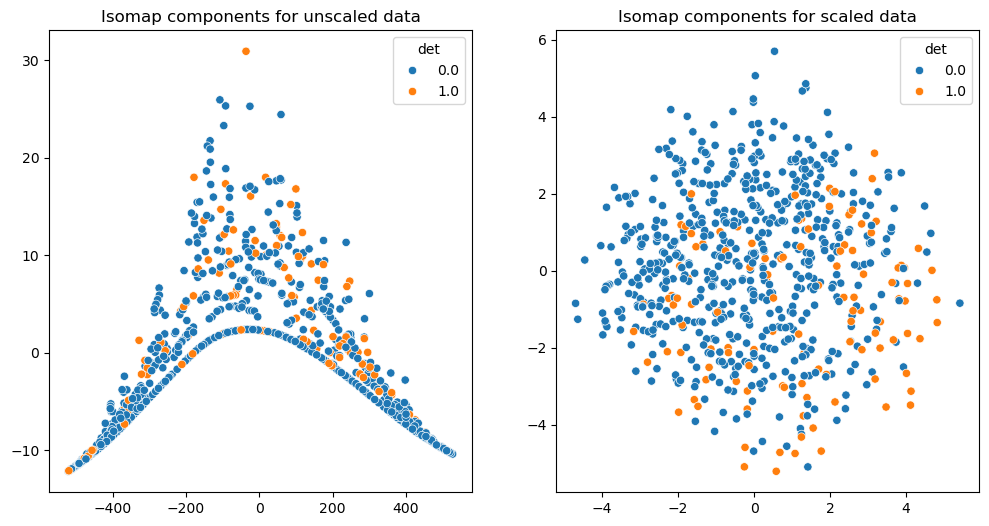

In [314]:
embedding = Isomap(n_components=7, n_neighbors=10)

X_train_isomap = embedding.fit_transform(X_train)
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,2,1)
sns.scatterplot(x = X_train_isomap[:, 0], y = X_train_isomap[:,1], hue = y_train)
plt.title('Isomap components for unscaled data')

X_train_scaled_isomap = embedding.fit_transform(X_train_scaled)
ax2 = fig.add_subplot(1,2,2)
sns.scatterplot(x = X_train_scaled_isomap[:, 0], y = X_train_scaled_isomap[:,1], hue = y_train)
plt.title('Isomap components for scaled data');

Optimal C for the unscaled PCA: 0.1624

Optimal C for the standardized data with PCA: 1.83


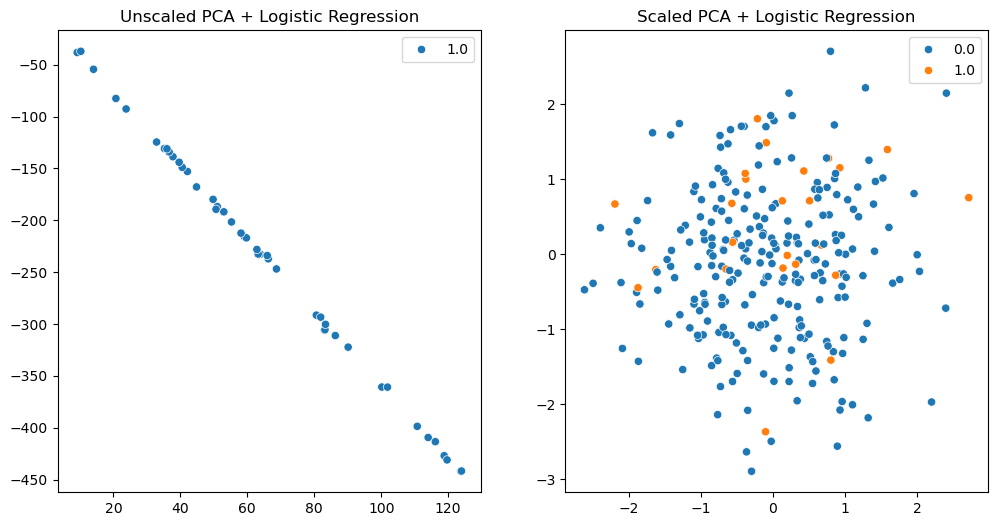

In [315]:
Cs = np.logspace(-5, 5, 20)
unscaled_clf = make_pipeline(pca, LogisticRegressionCV(Cs=Cs, solver = 'sag',max_iter=5000))
unscaled_clf.fit(X_train, y_train)
#Cs = np.linspace(-5, 15, 20)
scaled_clf = make_pipeline(scaler, pca, LogisticRegressionCV(Cs=Cs, solver = 'sag',max_iter=5000))
scaled_clf.fit(X_train, y_train)

print(f"Optimal C for the unscaled PCA: {unscaled_clf[-1].C_[0]:.4f}\n")
print(f"Optimal C for the standardized data with PCA: {scaled_clf[-1].C_[0]:.2f}")


y_pred = unscaled_clf.predict(X_test)
y_pred_scaled = scaled_clf.predict(X_test)
y_proba = unscaled_clf.predict_proba(X_test)
y_proba_scaled = scaled_clf.predict_proba(X_test)

fig = plt.figure(figsize =(12,6))
ax = fig.add_subplot(1,2,1)

X_test_transformed = pca.transform(X_test)
condition = (y_pred == y_test)
sns.scatterplot(x=X_test_transformed[condition][:,0], y = X_test_transformed[condition][:,1], hue=y_pred[condition])
plt.title('Unscaled PCA + Logistic Regression');

X_test_scaled_transformed = pca.transform(X_test_scaled)
ax2 = fig.add_subplot(1,2,2)
condition = (y_pred_scaled == y_test)
sns.scatterplot(x=X_test_scaled_transformed[condition][:,0], y = X_test_scaled_transformed[condition][:,1], hue=y_pred_scaled[condition])
plt.title('Scaled PCA + Logistic Regression');

Optimal C for the unscaled Isomap: 0.0000

Optimal C for the standardized data with Isomap: 0.16


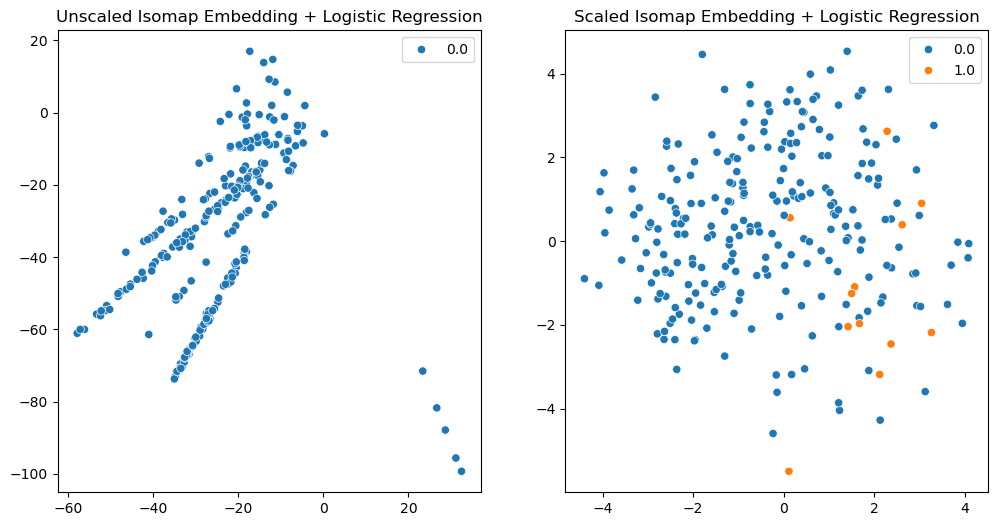

In [316]:
Cs = np.logspace(-5, 5, 20)
unscaled_clf = LogisticRegressionCV(Cs=Cs, solver = 'sag',max_iter=5000)
unscaled_clf.fit(X_train_isomap, y_train)
scaled_clf = LogisticRegressionCV(Cs=Cs, solver = 'sag',max_iter=5000)
scaled_clf.fit(X_train_scaled_isomap, y_train)

print(f"Optimal C for the unscaled Isomap: {unscaled_clf.C_[0]:.4f}\n")
print(f"Optimal C for the standardized data with Isomap: {scaled_clf.C_[0]:.2f}")

X_test_isomap = embedding.transform(X_test)
X_test_isomap_scaled = embedding.transform(X_test_scaled)
y_pred = unscaled_clf.predict(X_test_isomap)
y_pred_scaled = scaled_clf.predict(X_test_isomap_scaled)
y_proba = unscaled_clf.predict_proba(X_test_isomap)
y_proba_scaled = scaled_clf.predict_proba(X_test_isomap_scaled)

fig = plt.figure(figsize =(12,6))
ax = fig.add_subplot(1,2,1)

condition = (y_pred == y_test)
sns.scatterplot(x=X_test_isomap[condition][:,0], y = X_test_isomap[condition][:,1], hue=y_pred[condition])
plt.title('Unscaled Isomap Embedding + Logistic Regression')

ax2 = fig.add_subplot(1,2,2)
condition = (y_pred_scaled == y_test)
sns.scatterplot(x=X_test_isomap_scaled[condition][:,0], y = X_test_isomap_scaled[condition][:,1], hue=y_pred_scaled[condition])
plt.title('Scaled Isomap Embedding + Logistic Regression');

In [317]:
completeness_test = np.zeros(2)
contamination_test = np.zeros(2)

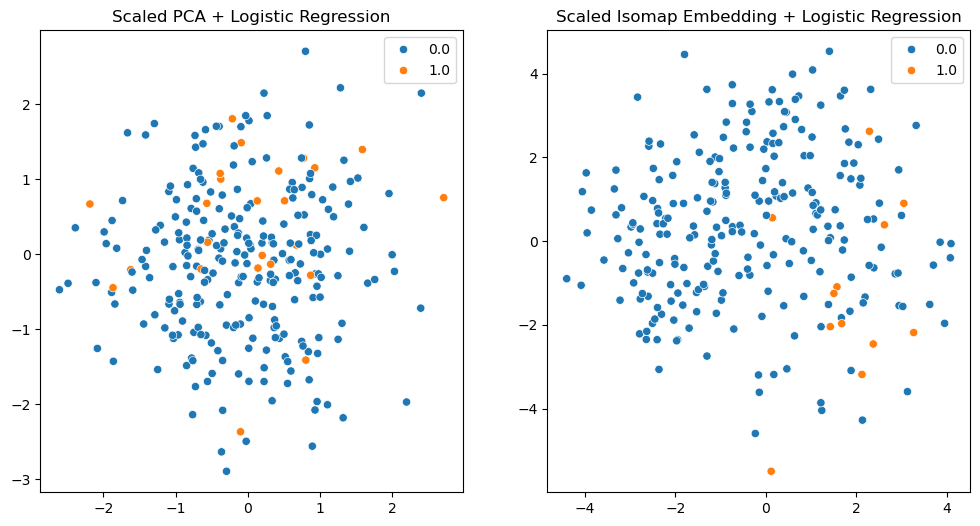

In [318]:
Cs = np.logspace(-5, 5, 20)
scaled_clf = make_pipeline(scaler, pca, LogisticRegressionCV(Cs=Cs, solver = 'sag',max_iter=5000))
scaled_clf.fit(X_train, y_train)

y_pred_scaled = scaled_clf.predict(X_test)
y_proba_scaled = scaled_clf.predict_proba(X_test)

fig = plt.figure(figsize =(12,6))

ax = fig.add_subplot(1,2,1)
condition = (y_pred_scaled == y_test)
sns.scatterplot(x=X_test_scaled_transformed[condition][:,0], y = X_test_scaled_transformed[condition][:,1], hue=y_pred_scaled[condition])
plt.title('Scaled PCA + Logistic Regression')

Conf_matrix_PCA = confusion_matrix(y_test, y_pred_scaled)
tn, fp, fn, tp = Conf_matrix_PCA.ravel()
completeness_test[0] = tp/(tp+fn)
contamination_test[0] = fp/(tp+fp)

accuracy_unscaled_pca = accuracy_score(y_test, y_pred)
accuracy_scaled_pca = accuracy_score(y_test, y_pred_scaled)

Cs = np.logspace(-5, 5, 20)
scaled_clf = LogisticRegressionCV(Cs=Cs, solver = 'sag',max_iter=5000)
scaled_clf.fit(X_train_scaled_isomap, y_train)


X_test_scaled_isomap = embedding.transform(X_test_scaled)

y_pred_scaled = scaled_clf.predict(X_test_scaled_isomap)
y_proba_scaled = scaled_clf.predict_proba(X_test_scaled_isomap)


Conf_matrix_Isomap = confusion_matrix(y_test, y_pred_scaled)
tn, fp, fn, tp = Conf_matrix_Isomap.ravel()
completeness_test[1] = tp/(tp+fn)
contamination_test[1] = fp/(tp+fp)


ax2 = fig.add_subplot(1,2,2)
condition = (y_pred_scaled == y_test)
sns.scatterplot(x=X_test_scaled_isomap[condition][:,0], y = X_test_scaled_isomap[condition][:,1], hue=y_pred_scaled[condition])
plt.title('Scaled Isomap Embedding + Logistic Regression');

In [319]:
print('Test accuracy for the unscaled dataset:')
print(f'{accuracy_unscaled:.2%}')
print('Test accuracy for the standardized dataset: ')
print(f'{accuracy_scaled:.2%}\n')

print("Test accuracy for the unscaled PCA")
print(f"{accuracy_unscaled_pca:.2%}")
print("Test accuracy for the standardized data with PCA")
print(f"{accuracy_scaled_pca:.2%}\n")

print("Test accuracy for the unscaled ISOMAP")
print(f"{accuracy_score(y_test, y_pred):.2%}")
print("Test accuracy for the standardized data with ISOMAP")
print(f"{accuracy_score(y_test, y_pred_scaled):.2%}\n")

Test accuracy for the unscaled dataset:
89.00%
Test accuracy for the standardized dataset: 
95.33%

Test accuracy for the unscaled PCA
85.33%
Test accuracy for the standardized data with PCA
90.00%

Test accuracy for the unscaled ISOMAP
85.33%
Test accuracy for the standardized data with ISOMAP
85.00%



In [320]:
print('Confusion matrix for scaled dataset:\n', Conf_matrix)
print('Confusion matrix for scaled PCA:\n', Conf_matrix_PCA)
print('Confusion matrix for scaled Isomap:\n',Conf_matrix_Isomap)

Confusion matrix for scaled dataset:
 [[243  13]
 [  1  43]]
Confusion matrix for scaled PCA:
 [[246  10]
 [ 20  24]]
Confusion matrix for scaled Isomap:
 [[243  13]
 [ 32  12]]


In [321]:
print('Completeness for scaled dataset: %0.4f' % completeness_test_dataset)
print('Completeness for scaled PCA: %0.4f' % completeness_test[0])
print('Completeness for scaled Isomap: %0.4f' %completeness_test[1])

Completeness for scaled dataset: 0.9773
Completeness for scaled PCA: 0.5455
Completeness for scaled Isomap: 0.2727


In [322]:
print('Contamination for scaled dataset: %0.4f' % contamination_test_dataset)
print('Contamination for scaled PCA: %0.4f' % contamination_test[0])
print('Contamination for scaled Isomap: %0.4f'% contamination_test[1])

Contamination for scaled dataset: 0.2321
Contamination for scaled PCA: 0.2941
Contamination for scaled Isomap: 0.5200
